In [1]:
import torch
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Optimizer
import torch.nn as nn
import torch.nn.functional as F
from useful_functions import *
from optimizer import *
from model import *
from MNIST_data_process import *
import matplotlib.pyplot as plt
from tqdm import tqdm

In [20]:
m = loadmat('MNIST_digits_2_4.mat')
X_train = m['X_train']
y_train = m['y_train'].transpose().reshape(-1)
X_test = m["X_test"]
y_test = m["y_test"].transpose().reshape(-1)
y_train = np.where(y_train == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

In [39]:
torch.cuda.is_available()

False

### 1. Pull Sum, A=R,B=I,选取n=2(感觉上, n增大会让算法表现更不稳定?)

In [21]:
n=2
d=784
L=6216
A=get_xinmeng_like_matrix(n,seed=42).T
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A=R
B=I#get_B(A,u=9,n=n)
nodes_data = distribute_data(X=X_train, y=y_train, n_nodes=n)
h = np.stack([i for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L, d) 形状的数组
y = np.stack([j for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L) 形状的数组

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(A, dtype=torch.float32).to(device)
B = torch.tensor(B, dtype=torch.float32).to(device)
h_data = torch.tensor(h, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(h_data.size())

torch.Size([2, 6216, 784])


In [22]:
torch.manual_seed(40)
model_list=[SimpleNN() for _ in range(n)]
criterion=nn.BCELoss()

def closure():
    total_loss=0
    for i,model in enumerate(model_list):
        for param in model.parameters():
            param.requires_grad = True
        model.zero_grad()
        output=model(h_data[i])
        loss=criterion(output.view(-1),y_data[i])
        loss.backward()
        total_loss+=loss.item()
    return total_loss/(len(model_list))

def compute_accuracy(model_list, X_test, y_test):
    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for i, model in enumerate(model_list):
            outputs = model(X_test)
            predicted = (outputs > 0.5).float().view(-1) # 二分类的阈值设置为0.5
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy

criterion = nn.BCELoss()
optimizer = PullSum(model_list=model_list, lr=0.1, A=A, B=B,closure=closure)
loss_history,accuracy_history=[],[]
for epoch in tqdm(range(500), desc="Training Progress"):  # 假设训练10个epoch
    loss = optimizer.step(closure)  # 调用优化器的 step 方法，并传入 closure
    loss_history.append(loss)
    accuracy = compute_accuracy(model_list, X_test_tensor, y_test_tensor)  # 计算测试集上的准确率
    accuracy_history.append(accuracy)
    # 输出当前 epoch 的损失和准确率
    #print(f"Epoch [{epoch + 1}], Loss: {loss:.10f}, Accuracy: {100*accuracy:.10f}%")

Training Progress: 100%|██████████| 500/500 [00:44<00:00, 11.34it/s]


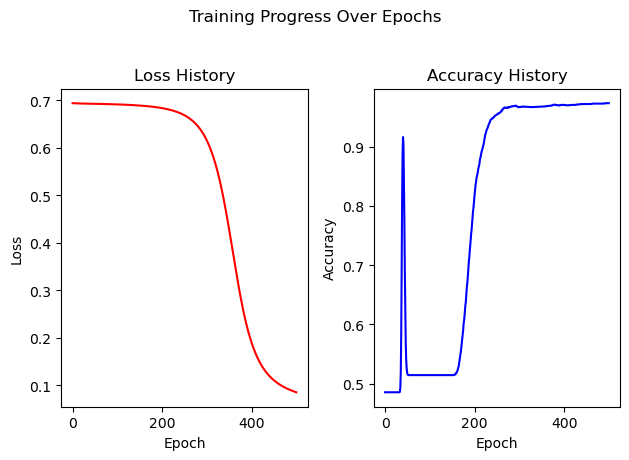

In [23]:
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='r')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, color='b')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('Training Progress Over Epochs')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

torch.Size([5, 2486, 784])


Training Progress: 100%|██████████| 1000/1000 [04:05<00:00,  4.08it/s]


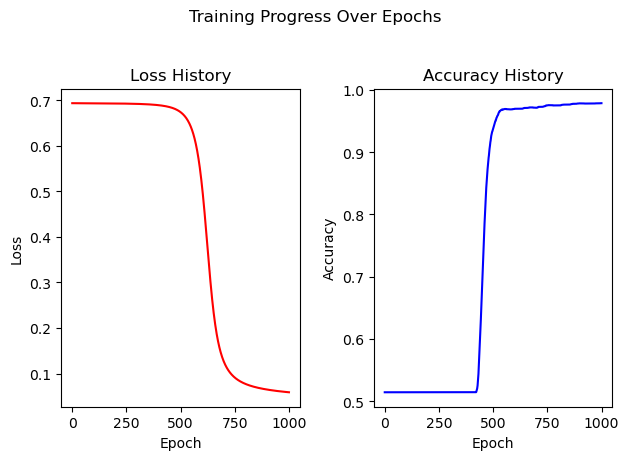

In [27]:
n=5
d=784
L=2486
A=get_xinmeng_like_matrix(n,seed=42).T
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A=R
B=I#get_B(A,u=9,n=n)
nodes_data = distribute_data(X=X_train, y=y_train, n_nodes=n)
h = np.stack([i for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L, d) 形状的数组
y = np.stack([j for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L) 形状的数组

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(A, dtype=torch.float32).to(device)
B = torch.tensor(B, dtype=torch.float32).to(device)
h_data = torch.tensor(h, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(h_data.size())

torch.manual_seed(40)
model_list=[SimpleNN() for _ in range(n)]
criterion=nn.BCELoss()

def closure():
    total_loss=0
    for i,model in enumerate(model_list):
        for param in model.parameters():
            param.requires_grad = True
        model.zero_grad()
        output=model(h_data[i])
        loss=criterion(output.view(-1),y_data[i])
        loss.backward()
        total_loss+=loss.item()
    return total_loss/(len(model_list))

def compute_accuracy(model_list, X_test, y_test):
    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for i, model in enumerate(model_list):
            outputs = model(X_test)
            predicted = (outputs > 0.5).float().view(-1) # 二分类的阈值设置为0.5
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy

criterion = nn.BCELoss()
optimizer = PullSum(model_list=model_list, lr=0.1, A=A, B=B,closure=closure)
loss_history,accuracy_history=[],[]
for epoch in tqdm(range(1000), desc="Training Progress"):  # 假设训练10个epoch
    loss = optimizer.step(closure)  # 调用优化器的 step 方法，并传入 closure
    loss_history.append(loss)
    accuracy = compute_accuracy(model_list, X_test_tensor, y_test_tensor)  # 计算测试集上的准确率
    accuracy_history.append(accuracy)
    # 输出当前 epoch 的损失和准确率
    #print(f"Epoch [{epoch + 1}], Loss: {loss:.10f}, Accuracy: {100*accuracy:.10f}%")

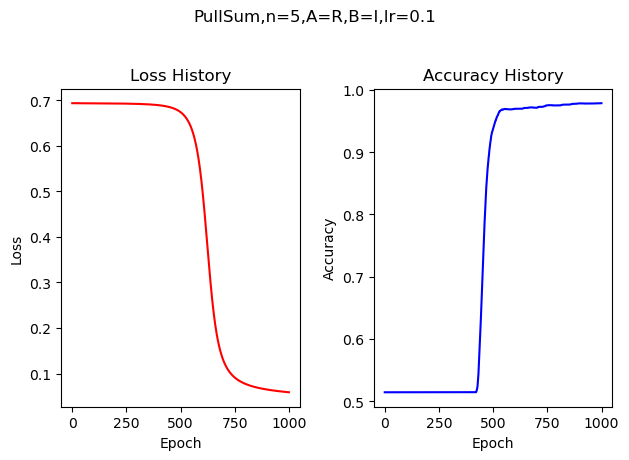

In [30]:
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='r')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, color='b')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('PullSum,n=5,A=R,B=I,lr=0.1')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
n=5
d=784
L=2486
A=get_xinmeng_like_matrix(n,seed=42).T
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
A=R
B=get_B(A,u=9,n=n)
nodes_data = distribute_data(X=X_train, y=y_train, n_nodes=n)
h = np.stack([i for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L, d) 形状的数组
y = np.stack([j for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L) 形状的数组

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(A, dtype=torch.float32).to(device)
B = torch.tensor(B, dtype=torch.float32).to(device)
h_data = torch.tensor(h, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(h_data.size())

torch.manual_seed(40)
model_list=[SimpleNN() for _ in range(n)]
criterion=nn.BCELoss()

def closure():
    total_loss=0
    for i,model in enumerate(model_list):
        for param in model.parameters():
            param.requires_grad = True
        model.zero_grad()
        output=model(h_data[i])
        loss=criterion(output.view(-1),y_data[i])
        loss.backward()
        total_loss+=loss.item()
    return total_loss/(len(model_list))

def compute_accuracy(model_list, X_test, y_test):
    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for i, model in enumerate(model_list):
            outputs = model(X_test)
            predicted = (outputs > 0.5).float().view(-1) # 二分类的阈值设置为0.5
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy

criterion = nn.BCELoss()
optimizer = PullSum(model_list=model_list, lr=0.1, A=A, B=B,closure=closure)
loss_history,accuracy_history=[],[]
for epoch in tqdm(range(1000), desc="Training Progress"):  # 假设训练10个epoch
    loss = optimizer.step(closure)  # 调用优化器的 step 方法，并传入 closure
    loss_history.append(loss)
    accuracy = compute_accuracy(model_list, X_test_tensor, y_test_tensor)  # 计算测试集上的准确率
    accuracy_history.append(accuracy)
    # 输出当前 epoch 的损失和准确率
    #print(f"Epoch [{epoch + 1}], Loss: {loss:.10f}, Accuracy: {100*accuracy:.10f}%")

torch.Size([5, 2486, 784])


Training Progress: 100%|██████████| 1000/1000 [06:12<00:00,  2.68it/s]


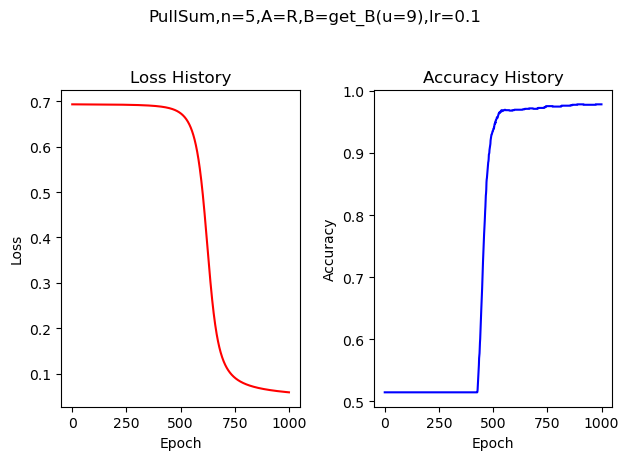

In [36]:
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='r')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, color='b')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('PullSum,n=5,A=R,B=get_B(u=9),lr=0.1')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [37]:
n=5
d=784
L=2486
A=get_xinmeng_like_matrix(n,seed=42).T
I=np.eye(n)
one=np.ones(n)
R=np.outer(one,one)/n
B=I#get_B(A,u=9,n=n)
nodes_data = distribute_data(X=X_train, y=y_train, n_nodes=n)
h = np.stack([i for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L, d) 形状的数组
y = np.stack([j for i, j in nodes_data], axis=0)  # 这将创建一个 (n, L) 形状的数组

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
A = torch.tensor(A, dtype=torch.float32).to(device)
B = torch.tensor(B, dtype=torch.float32).to(device)
h_data = torch.tensor(h, dtype=torch.float32).to(device)
y_data = torch.tensor(y, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(h_data.size())

torch.manual_seed(40)
model_list=[SimpleNN() for _ in range(n)]
criterion=nn.BCELoss()

def closure():
    total_loss=0
    for i,model in enumerate(model_list):
        for param in model.parameters():
            param.requires_grad = True
        model.zero_grad()
        output=model(h_data[i])
        loss=criterion(output.view(-1),y_data[i])
        loss.backward()
        total_loss+=loss.item()
    return total_loss/(len(model_list))

def compute_accuracy(model_list, X_test, y_test):
    correct = 0
    total = 0
    with torch.no_grad():  # 在评估模式下，不需要计算梯度
        for i, model in enumerate(model_list):
            outputs = model(X_test)
            predicted = (outputs > 0.5).float().view(-1) # 二分类的阈值设置为0.5
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()
    accuracy = correct / total
    return accuracy

criterion = nn.BCELoss()
optimizer = PullSum(model_list=model_list, lr=0.1, A=A, B=B,closure=closure)
loss_history,accuracy_history=[],[]
for epoch in tqdm(range(1000), desc="Training Progress"):  # 假设训练10个epoch
    loss = optimizer.step(closure)  # 调用优化器的 step 方法，并传入 closure
    loss_history.append(loss)
    accuracy = compute_accuracy(model_list, X_test_tensor, y_test_tensor)  # 计算测试集上的准确率
    accuracy_history.append(accuracy)
    # 输出当前 epoch 的损失和准确率
    #print(f"Epoch [{epoch + 1}], Loss: {loss:.10f}, Accuracy: {100*accuracy:.10f}%")

torch.Size([5, 2486, 784])


Training Progress: 100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


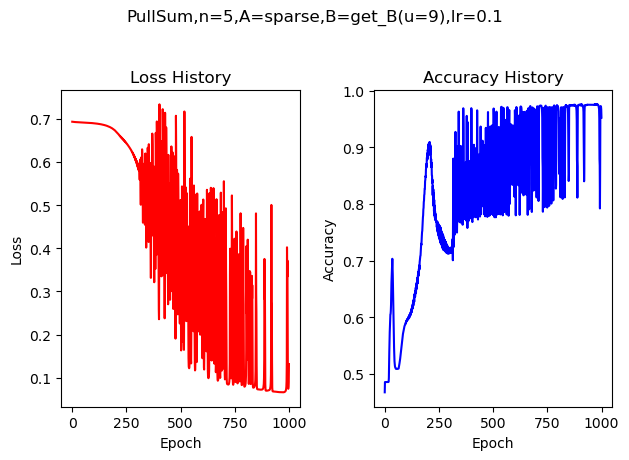

In [38]:
plt.subplot(1, 2, 1)
plt.plot(loss_history, color='r')
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, color='b')
plt.title('Accuracy History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.suptitle('PullSum,n=5,A=sparse,B=get_B(u=9),lr=0.1')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()